In questo caso andremo ad affrontare un problema di **classificazione multi-classe**, quindi, un problema in cui ci sono più di 2 classi.
Utilizzeremo il **Reuters Dataset**, che anche in questo caso, è già presente all'interno di keras. Tale dataset contiene 11,228 telegiornali, divisi in 46 topic/argomenti. L'obiettivo in questo caso, è associare ad un telegiornale un singolo topic, quindi abbiamo un problema **single-label**. Se invece, ogni istanza poteva essere classificato con più classi, avremo avuto un problema multi-label (multi-label multi-class classification).

Carichiamo il dataset da Keras

In [1]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [2]:
print(len(train_data))
print(len(test_data))

8982
2246


**Cosi come per l'imdb dataset, anche in questo caso il dataset è stato già pre-processato, e quindi, il testo è stato convertito in vettori di interi.**

**Le label vanno da 0 a 45.**

In [3]:
print(train_data[0])
print(train_labels[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


Quindi anche in questo caso, possiamo decodificare i vettori numerici per recuperare il testo originale tramite il dizionario di indici restituiti dal metodo get_word_index() che associa ad parola del vocabolario, l'indice attraverso il quale è stata codificata la parola stessa.

In [4]:
word_index = reuters.get_word_index()
reverse_word_index = dict(
  [(value, key) for (key, value) in word_index.items()])

decoded_newswire = " ".join(
  [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

In [5]:
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


**Anche in questo caso, prima di dare in input i dati alla nostra rete neurale, dobbiamo trasformarli in dei vettori di dimensione uguale, e inoltre, convertirli in dei tensori.**

In [6]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) #Inizialmente il tensore viene inizializzato con tutti valori 0
    for i, sequence in enumerate(sequences):
        for word in sequence:
          results[i, word] = 1.
    return results

In [7]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Per quanto riguarda le label, abbiamo due possibilità:

1) Come fatto in precedenza, possiamo semplicemente convertirle in degli array numerici (tramite np, in modo da ottenere dei tensori)

2) utilizzare anche in questo caso il one-hot encoding. Quindi rappresentare ogni label i-esima come un vettore di tutti 0, tranne un singolo 1 nell'indice i-esimo (che rappresenta il valore della label).

La tecnica dell'one-hot encoding è più utilizzata (rappresenta quasi uno standard), quindi, in questo caso la utilizzeremo.

In [8]:
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [9]:
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [10]:
print(x_train[0])
print(y_train[0]) #La prima label era 3, infatti, l'1 viene posizionato nella quarta posizione

[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Dopo aver fatto questo i dati sono pronti per essere dati in input al modello.

Quindi il passo successivo è definire l'architettura della Rete Neurale. La rete, inevitalbilmente sarà diverso rispetto quella di prima.

 Di base, andremo ad utilizzare sempre **2 layer densi intermedi + 1 layer denso finale** che si occuperà di restituire le probabilità di appartenenza alle classi.

 In precedenza ogni layer denso intermedio era stato definito con 16 unità in quanto si avevano "soltanto" 2 classi; in questo caso il numero delle classi è molto più alto (46), quindi il layer finale dovrà contenere necessariamente 46 unità. Di conseguenza, dobbiamo avere dei layer intermedi che hanno almeno 46 unità. Utilizzare solo 16 unità in un layer potrebbe comportare la perdita di informazioni rilevanti, che non verrebbero propagate ai layer successivi, e di conseguenza, irrecuperabili. Proprio per questo, rispetto a prima, faremo 4 principali modifiche:

**1) Le unità dei 2 layer densi intermedi passeranno da 16 a 64**

**2) Il layer denso finale non conterrà solo 1 unità, ma 46. Questo perchè il modello dovrà restituire una probabilità per ogni classe. Quindi deve restituire in totale 46 probabilità**

**3) Come funzione di attivazione del layer finale verrà utilizzata una softmax in modo che l'output grezzo della rete neurale (digits - valori float) venga convertiti in una distribuzione di probabilità.**

**4) La loss utilizzata è la categorical_loss che calcola la differenza tra la distribuzione di probabilità predetta dal modello e quella reale.**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])

In [12]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Abbiamo bisogno del validation test per validare il modello durante la fase di training. Preleviamo dal training set i primi 1000 sample da utilizzare come validation set

In [13]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

**Alleniamo il modello per 20 epoche.**

In [14]:
history = model.fit(
    partial_x_train,
  	partial_y_train,
  	epochs=20,
  	batch_size=512,
  	validation_data=(x_val, y_val)
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4175 - loss: 3.1849 - val_accuracy: 0.6170 - val_loss: 1.8224
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6531 - loss: 1.6211 - val_accuracy: 0.6840 - val_loss: 1.3696
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7266 - loss: 1.2079 - val_accuracy: 0.7390 - val_loss: 1.1843
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7898 - loss: 0.9603 - val_accuracy: 0.7730 - val_loss: 1.0809
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8250 - loss: 0.8222 - val_accuracy: 0.7850 - val_loss: 1.0042
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8590 - loss: 0.6641 - val_accuracy: 0.8030 - val_loss: 0.9701
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8780 - loss: 0.5743 - val_accuracy: 0.8020 - val_loss: 0.9276
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9012 - loss: 0.4597 - val_accuracy: 0.8090 - 

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**Il modello inizia a overfittare dopo circa 9 epoche.**

In [16]:
import matplotlib.pyplot as plt

def loss_plot(history):
  loss_values = history.history["loss"]
  val_loss_values = history.history["val_loss"]
  epochs = range(1, len(loss_values) + 1)

  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.show()

In [17]:
def accuracy_plot(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, "bo", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

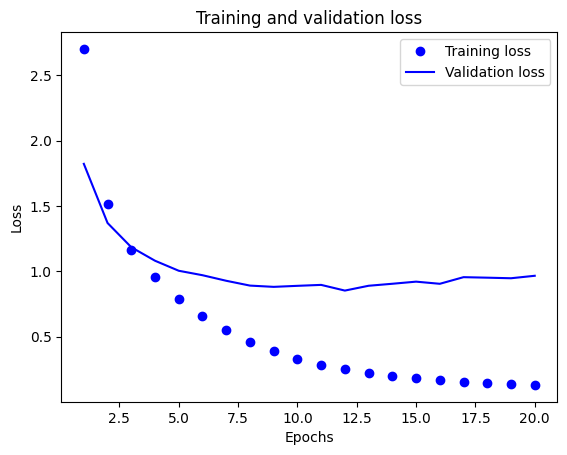

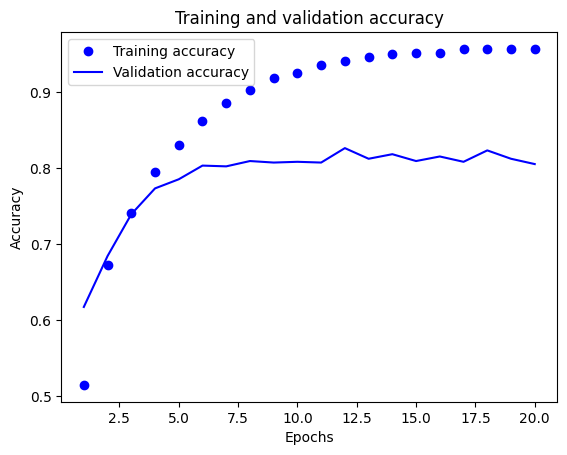

In [18]:
loss_plot(history=history)
accuracy_plot(history=history)

**Il modello ha comunque un accuracy media del 80%**

In [19]:
predictions = model.predict(x_test)
predictions

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[2.2523148e-08, 5.3320459e-06, 1.5266974e-09, ..., 1.1453628e-08,
        2.1166220e-07, 1.7375287e-08],
       [1.0130276e-03, 1.3998964e-01, 3.7656384e-05, ..., 8.9019460e-07,
        8.6022885e-07, 2.5880299e-06],
       [3.1186384e-03, 9.7600651e-01, 3.0069981e-05, ..., 4.3399577e-05,
        6.7602023e-06, 2.0175548e-06],
       ...,
       [1.9502813e-06, 5.4300359e-05, 1.1533950e-06, ..., 4.4064132e-06,
        9.0921721e-06, 1.0444630e-06],
       [7.0350379e-04, 1.5076781e-02, 1.8159232e-04, ..., 7.7693851e-04,
        3.3725682e-04, 3.6219833e-04],
       [4.2833103e-04, 7.0672840e-01, 3.1128761e-03, ..., 4.7272657e-05,
        1.7302844e-05, 1.7940862e-07]], dtype=float32)

In [20]:
print(predictions[0].shape)
print(np.sum(predictions[0]))
print(np.argmax(predictions[0]))

(46,)
1.0
3


Come detto in precedenza, a**vendo un layer finale composto da 46 unità, dovremmo evitare di utilizzare dei layer intermedi con meno di 46 unità**, in modo da evitare il cosìdetto **bottleneck**, cioè layer che non sono in grado di memorizzare informazioni rilevanti del problema.

**Proviamo a vedere cosa succede se utilizzassimo un layer denso intermedio con un numero molto più basso di unità, per esempio 4.**

In [21]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(4, activation="relu"),
  layers.Dense(46, activation="softmax")
  ])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.1363 - loss: 3.3022 - val_accuracy: 0.4220 - val_loss: 2.2449
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4775 - loss: 2.0086 - val_accuracy: 0.6600 - val_loss: 1.5397
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7108 - loss: 1.3504 - val_accuracy: 0.6960 - val_loss: 1.3242
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7188 - loss: 1.1704 - val_accuracy: 0.7100 - val_loss: 1.2669
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7393 - loss: 1.0535 - val_accuracy: 0.7080 - val_loss: 1.2456
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7635 - loss: 0.9346 - val_accuracy: 0.7020 - val_loss: 1.2464
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7784 - loss: 0.8606 - val_accuracy: 0.7190 - val_loss: 1.2287
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7875 - loss: 0.8139 - val_accuracy: 0.7190 - v

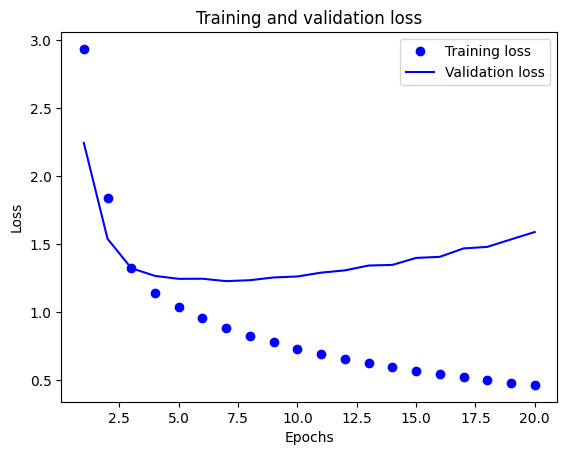

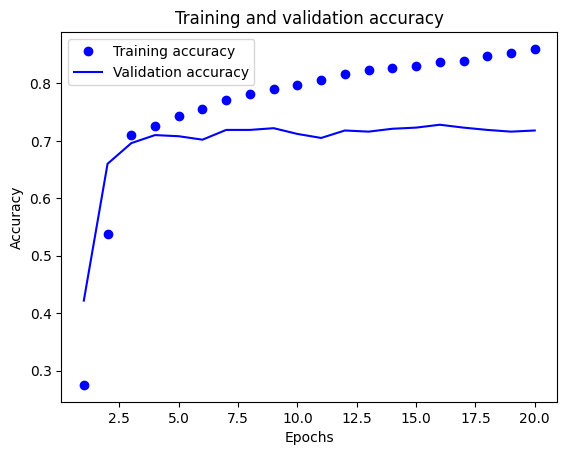

In [22]:
loss_plot(history)
accuracy_plot(history)

**In questo caso l'accuracy è scesa dall'80% al 71%.**

**Questo decremento è dovuto maggiormente al fatto che stiamo cercando di comprimere tante informazioni (informazioni sufficienti a recuperare gli iperpiani di separazione di 46 classi) in uno spazio intermedio con poche dimensioni.**

**Il modello è in grado di stipare la maggior parte delle informazioni necessarie in queste rappresentazioni quadridimensionali, ma non tutte.**

Proviamo a vedere invece cosa succede se aumentiamo il numero di unità dei layer densi intermedi da 64 a 128:

In [ ]:
model = keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(46, activation="softmax")
  ])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5437 - loss: 2.2080 - val_accuracy: 0.7210 - val_loss: 1.1882
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8172 - loss: 0.8469 - val_accuracy: 0.7890 - val_loss: 0.9464
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8884 - loss: 0.4995 - val_accuracy: 0.8310 - val_loss: 0.8110
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9325 - loss: 0.3205 - val_accuracy: 0.8130 - val_loss: 0.8915
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9488 - loss: 0.2236 - val_accuracy: 0.8200 - val_loss: 0.8730
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9511 - loss: 0.1864 - val_accuracy: 0.8240 - val_loss: 0.8935
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9601 - loss: 0.1563 - val_accuracy: 0.8130 - val_loss: 0.9580
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9575 - loss: 0.1533 - val_accuracy: 0.8140 - v

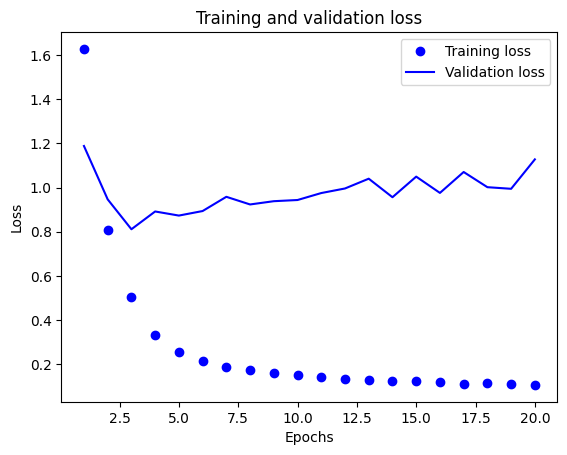

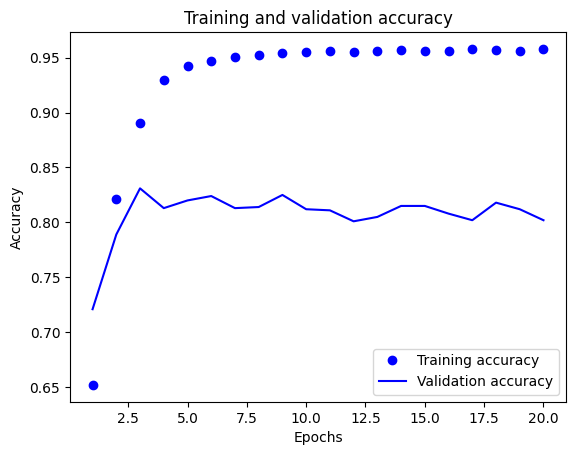

In [24]:
loss_plot(history)
accuracy_plot(history)

**In questo caso l'accuracy ha avuto un leggero aumento ~82-83%**. Quindi non c'è stata una grande variazione raddoppiando il numero di unità. Quindi si potrebbe pensare che il gioco non vale la candela, cioè potrebbe non avere senso raddoppiare la dimensionalità della rete per ottenere quasi gli stessi risultati di una rete  più piccola, e quindi più veloce da allenare.

In [25]:
model = keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(46, activation="softmax")
  ])

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4358 - loss: 2.5222 - val_accuracy: 0.6730 - val_loss: 1.4039
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6796 - loss: 1.3883 - val_accuracy: 0.7360 - val_loss: 1.1659
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7382 - loss: 1.1304 - val_accuracy: 0.7650 - val_loss: 1.0482
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7753 - loss: 0.9609 - val_accuracy: 0.7820 - val_loss: 0.9889
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8051 - loss: 0.8217 - val_accuracy: 0.8070 - val_loss: 0.9406
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8343 - loss: 0.7091 - val_accuracy: 0.8010 - val_loss: 0.9465
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8543 - loss: 0.6041 - val_accuracy: 0.8170 - val_loss: 0.9223
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8615 - loss: 0.5530 - val_accuracy: 0.8130 - v

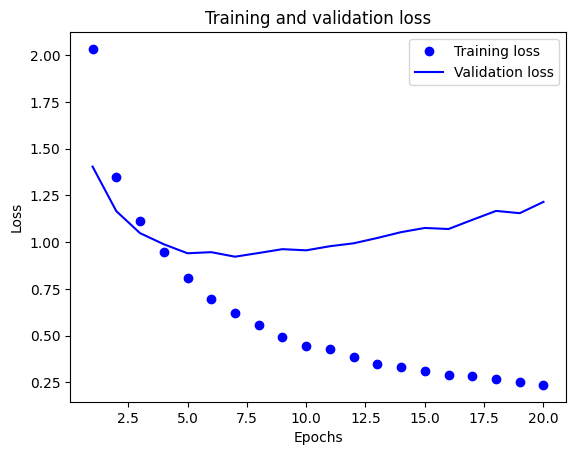

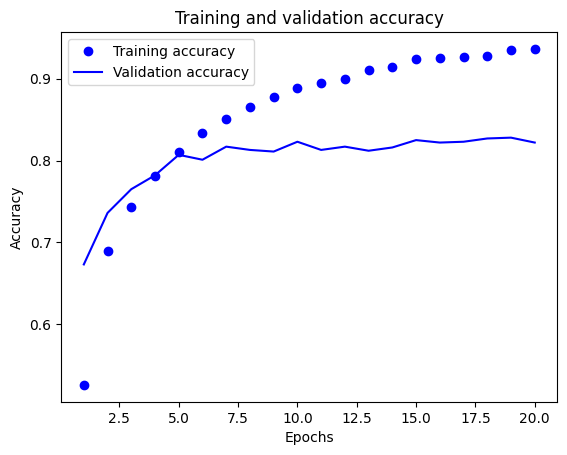

In [26]:
loss_plot(history)
accuracy_plot(history)

Visto che ci sono tante combinazioni che si potrebbero provare per vedere come si comporta la rete, **utilizzo direttamente una GridSerch**, in modo da trovare la miglior combinazione dei valori da associare agli iperparametri. Trattandosi di una GridSearch dobbiamo associare ad ogni iperparametro l'insieme di valori che la GridSearch dovrà provare. Quindi verà allenato un modello per ogni possibile combinazione, che verrà successivamente Valutato tramite una fase di validation.
Così facendo conosceremo le performance di ogni combinazione e potremmo scegliere la combinazione di iperparametri che genera il modello migliore.

In [27]:
#Grid di iperparametri da esplorare

param_grid = {
    'model__optimizer': ['rmsprop', 'adam'],
    'model__dropout_rate': [0.2, 0.5],
    'model__activation': ['relu', 'tanh'],
    'model__n_units': [64, 128],
    'batch_size': [128, 256],
    'epochs': [5,20],
}

In [28]:
#!pip install scikeras
#!pip uninstall -y scikit-learn
#!pip install scikit-learn==1.3.1

In [29]:
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier

def build_model(optimizer='rmsprop', dropout_rate=0.5, activation='relu', n_units=64):
    model = keras.Sequential([
        layers.Dense(n_units, activation=activation, input_shape=(partial_x_train.shape[1],)),
        layers.Dropout(dropout_rate),
        layers.Dense(n_units, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(46, activation='softmax')  # 46 classi nel dataset Reuters
    ])

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import GridSearchCV

# KerasClassifier wrapper
model = KerasClassifier(build_fn=build_model, verbose=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Esegui la grid search
grid_result = grid.fit(partial_x_train, partial_y_train)

In [31]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.778502 (0.006544) with: {'batch_size': 128, 'epochs': 5, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__n_units': 64, 'model__optimizer': 'rmsprop'}
0.781008 (0.002760) with: {'batch_size': 128, 'epochs': 5, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__n_units': 64, 'model__optimizer': 'adam'}
0.800050 (0.002447) with: {'batch_size': 128, 'epochs': 5, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__n_units': 128, 'model__optimizer': 'rmsprop'}
0.804686 (0.006894) with: {'batch_size': 128, 'epochs': 5, 'model__activation': 'relu', 'model__dropout_rate': 0.2, 'model__n_units': 128, 'model__optimizer': 'adam'}
0.722126 (0.010757) with: {'batch_size': 128, 'epochs': 5, 'model__activation': 'relu', 'model__dropout_rate': 0.5, 'model__n_units': 64, 'model__optimizer': 'rmsprop'}
0.722878 (0.008408) with: {'batch_size': 128, 'epochs': 5, 'model__activation': 'relu', 'model__dropout_rate': 0.5, 'model__n_units': 64, 'model__optimizer': '

In [32]:
best_model = grid_result.best_estimator_

print("Best Score: {:.4f} using {}".format(grid_result.best_score_, grid_result.best_params_))

Best Score: 0.8123 using {'batch_size': 128, 'epochs': 20, 'model__activation': 'relu', 'model__dropout_rate': 0.5, 'model__n_units': 128, 'model__optimizer': 'adam'}


In [ ]:
#Alleniamo un nuovo modello con i parametri migliori restituiti dalla gridSearch

model = keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(46, activation="softmax")
  ])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3479 - loss: 2.9529 - val_accuracy: 0.6550 - val_loss: 1.4704
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6450 - loss: 1.4788 - val_accuracy: 0.7150 - val_loss: 1.2167
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7291 - loss: 1.1486 - val_accuracy: 0.7630 - val_loss: 1.0768
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7657 - loss: 0.9689 - val_accuracy: 0.7820 - val_loss: 1.0036
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8074 - loss: 0.7943 - val_accuracy: 0.8060 - val_loss: 0.9455
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8420 - loss: 0.6370 - val_accuracy: 0.8170 - val_loss: 0.9155
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8720 - loss: 0.5152 - val_accuracy: 0.8180 - val_loss: 0.9003
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8720 - loss: 0.4986 - val_accuracy: 0.8250 - v

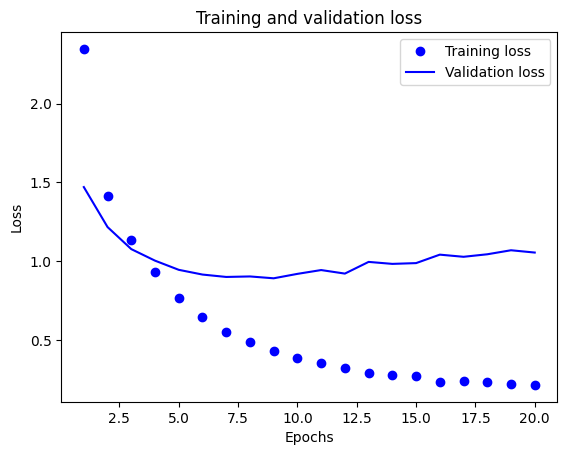

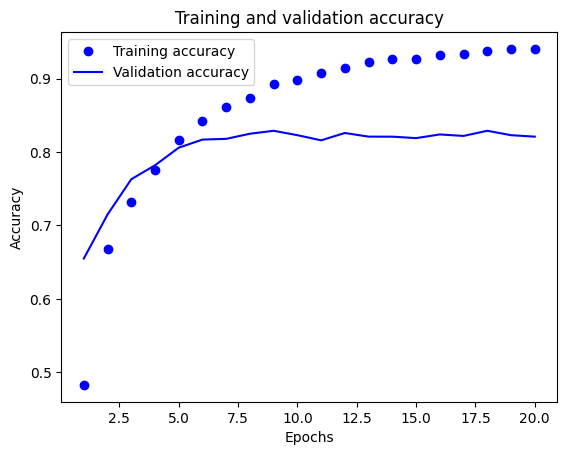

In [36]:
loss_plot(history)
accuracy_plot(history)